In [2]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import colors, cm, pyplot as plt
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

In [3]:
CONVERTED_DATABASE = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-190719_Hela_Ecoli_1to1_01-converted.sqlite'

# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8


In [4]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
ms1_frame_properties_df = pd.read_sql_query("select Id,Time from frame_properties where MsMsType == {}".format(FRAME_TYPE_MS1), db_conn)
ms1_frame_ids = tuple(ms1_frame_properties_df.Id)
db_conn.close()

We consider a pixel to be an m/z bin. To maintain consistency with previous labelled training sets, and because it looks good for visual inspection, we will keep the tiles to be 18.0 Da wide.

In [10]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines

MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1

MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1

In [13]:
MZ_BIN_WIDTH = MZ_PER_TILE / PIXELS_X
MZ_BIN_WIDTH

0.01978021978021978

In [78]:
def mz_from_tile_pixel(tile_id, pixel_x):
    assert (pixel_x >= 0) and (pixel_x <= PIXELS_X), "pixel_x not in range"
    assert (tile_id >= 0) and (tile_id <= TILES_PER_FRAME-1), "tile_id not in range"
    
    mz = (tile_id * MZ_PER_TILE) + ((pixel_x / PIXELS_X) * MZ_PER_TILE) + MZ_MIN
    return mz

In [90]:
mz = mz_from_tile_pixel(2,900)
mz

153.8021978021978

In [95]:
tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
tile_id

2

In [97]:
pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
pixel_x

900

In [24]:
def tile_pixel_x_from_mz(mz):
    tile_id = int((mz - MZ_MIN) / MZ_PER_TILE)
    pixel_x = int(((mz - MZ_MIN) % MZ_PER_TILE) / MZ_PER_TILE * PIXELS_X)
    return (tile_id, pixel_x)

In [16]:
# choose a frame to test
FRAME_ID = ms1_frame_ids[int(len(ms1_frame_ids) / 2)]
FRAME_ID

5964

In [50]:
db_conn = sqlite3.connect(CONVERTED_DATABASE)
raw_points_df = pd.read_sql_query("select mz,scan,intensity from frames where frame_id == {}".format(FRAME_ID), db_conn)
db_conn.close()

In [51]:
tile_pixels_df = pd.DataFrame(raw_points_df.apply(lambda row: tile_pixel_x_from_mz(row.mz), axis=1).tolist(), columns=['tile_id', 'pixel_x'])

In [52]:
raw_points_df = pd.concat([raw_points_df, tile_pixels_df], axis=1)

In [53]:
raw_points_df.head()

,mz,scan,intensity,tile_id,pixel_x
0,374.217109,815,100,15,213
1,389.253581,734,9,16,63
2,403.227936,708,80,16,769
3,403.227936,710,21,16,769
4,403.227936,724,113,16,769


In [55]:
raw_points_df.tile_id.min(),raw_points_df.tile_id.max()

(15, 80)

In [74]:
pixel_intensity_df = raw_points_df.groupby(by=['tile_id', 'pixel_x', 'scan'], as_index=False).intensity.sum()

In [75]:
type(pixel_intensity_df)

pandas.core.frame.DataFrame

In [76]:
pixel_intensity_df.head(20)

,tile_id,pixel_x,scan,intensity
0,15,213,815,100
1,16,63,734,9
2,16,769,708,80
3,16,769,710,21
4,16,769,724,113
5,16,770,711,32
6,16,770,715,92
7,16,770,716,52
8,16,770,721,127
9,16,770,723,110


In [78]:
pixel_intensity_df.intensity.min()

9

In [80]:
# calculate the colour to represent the intensity
colour_map = cm.get_cmap(name='magma')
norm = colors.LogNorm(vmin=1, vmax=5e3, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else


In [81]:
# calculate the colour to represent the intensity
colour_l = []
for r in zip(pixel_intensity_df.intensity):
    colour_l.append((colour_map(norm(r[0]), bytes=True)[:3]))
pixel_intensity_df['colour'] = colour_l

In [82]:
pixel_intensity_df.head()

,tile_id,pixel_x,scan,intensity,colour
0,15,213,815,100,"(198, 60, 115)"
1,16,63,734,9,"(83, 19, 124)"
2,16,769,708,80,"(187, 56, 119)"
3,16,769,710,21,"(122, 34, 129)"
4,16,769,724,113,"(205, 63, 112)"


In [84]:
pixel_intensity_df.loc[pixel_intensity_df.intensity.idxmax()]

tile_id                   34
pixel_x                  118
scan                      78
intensity              11599
colour       (251, 252, 191)
Name: 76944, dtype: object

In [87]:
tile_33_df = pixel_intensity_df[(pixel_intensity_df.tile_id == 33)]

In [96]:
tile_33_df.head()

,tile_id,pixel_x,scan,intensity,colour
64408,33,13,89,96,"(197, 60, 116)"
64409,33,13,92,112,"(203, 62, 113)"
64410,33,13,97,74,"(184, 55, 120)"
64411,33,13,102,76,"(185, 55, 120)"
64412,33,13,106,81,"(189, 57, 119)"


In [136]:
# create an image of the whole frame
tile_im_array = np.zeros([PIXELS_Y+1, PIXELS_X+1, 3], dtype=np.uint8)  # container for the image
for r in zip(tile_33_df.pixel_x, tile_33_df.scan, tile_33_df.colour):
    x = r[0]
    y = r[1]
    c = r[2]
    tile_im_array[y,x,:] = c

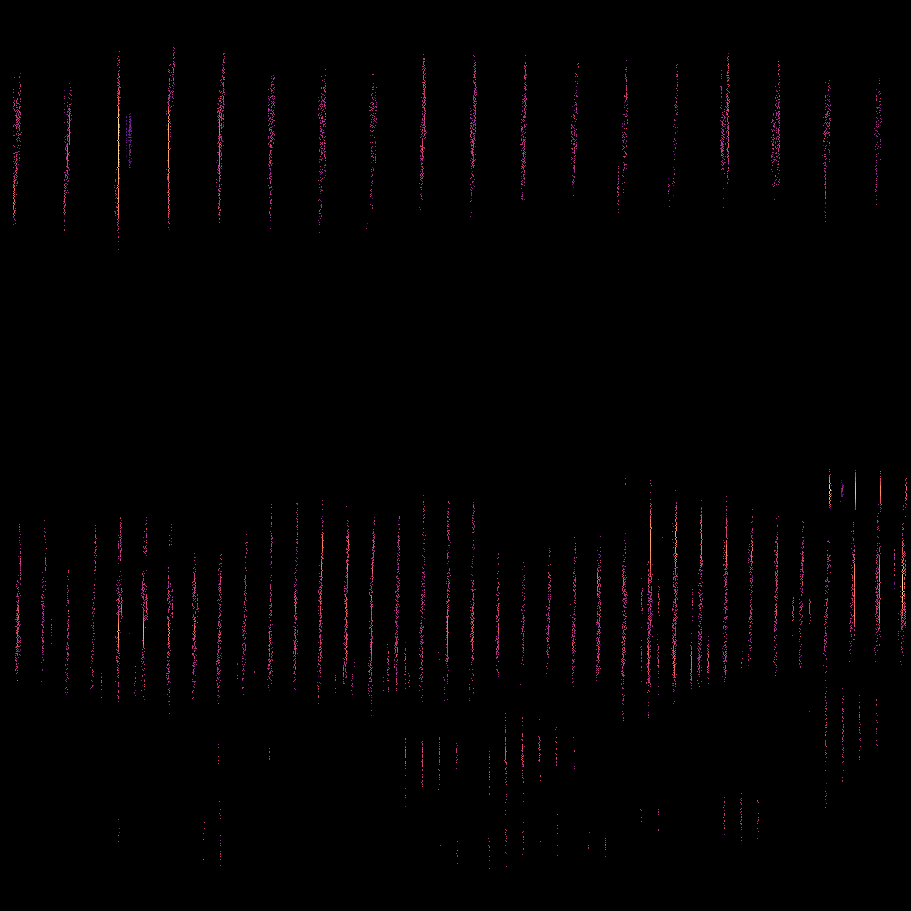

In [137]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [138]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile.png')

In [139]:
z = np.array([0,0,0])
for x in range(4, PIXELS_X-4):
    for y in range(4, PIXELS_Y-4):
        c = tile_im_array[y,x]
        if (c == z).all():
            n = []
            n.append(tile_im_array[y+1,x-1])
            n.append(tile_im_array[y+1,x])
            n.append(tile_im_array[y+1,x+1])
            
            n.append(tile_im_array[y-1,x-1])
            n.append(tile_im_array[y-1,x])
            n.append(tile_im_array[y-1,x+1])

            n.append(tile_im_array[y+2,x-1])
            n.append(tile_im_array[y+2,x])
            n.append(tile_im_array[y+2,x+1])
            
            n.append(tile_im_array[y-2,x-1])
            n.append(tile_im_array[y-2,x])
            n.append(tile_im_array[y-2,x+1])

            n.append(tile_im_array[y+3,x-1])
            n.append(tile_im_array[y+3,x])
            n.append(tile_im_array[y+3,x+1])
            
            n.append(tile_im_array[y-3,x-1])
            n.append(tile_im_array[y-3,x])
            n.append(tile_im_array[y-3,x+1])

            n.append(tile_im_array[y+4,x-1])
            n.append(tile_im_array[y+4,x])
            n.append(tile_im_array[y+4,x+1])
            
            n.append(tile_im_array[y-4,x-1])
            n.append(tile_im_array[y-4,x])
            n.append(tile_im_array[y-4,x+1])

            n.append(tile_im_array[y,x-1])
            n.append(tile_im_array[y,x+1])
            
            neighbours_a = np.array(n)
            tile_im_array[y,x] = np.mean(neighbours_a, axis=0)

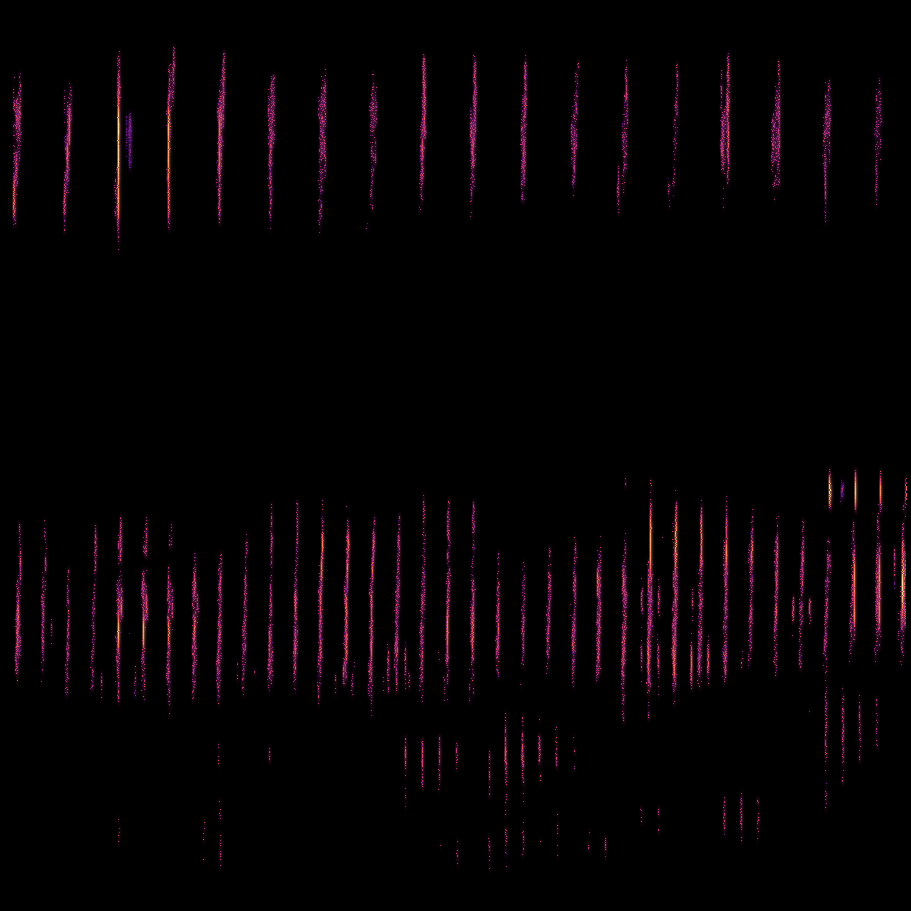

In [140]:
tile = Image.fromarray(tile_im_array, 'RGB')
tile

In [141]:
tile.save('/Users/darylwilding-mcbride/Downloads/prototype-tile-average-filled.png')